# LSTM Model

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [15]:
!pip install keras
!pip install tensorflow

from keras.models import Sequential
from keras.layers import Dense, LSTM

from sklearn.preprocessing import MinMaxScaler

plt.style.use('fivethirtyeight')

In [16]:
#Dataset ^GSPC for example!

df = yf.download("^GSPC", start="2012-11-25", end="2022-11-25")
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-11-26,1409.150024,1409.150024,1397.680054,1406.290039,1406.290039,2948960000
2012-11-27,1406.290039,1409.010010,1398.030029,1398.939941,1398.939941,3323120000
2012-11-28,1398.770020,1410.310059,1385.430054,1409.930054,1409.930054,3359250000
2012-11-29,1409.959961,1419.699951,1409.040039,1415.949951,1415.949951,3356850000
2012-11-30,1415.949951,1418.859985,1411.630005,1416.180054,1416.180054,3966000000
...,...,...,...,...,...,...
2022-11-17,3919.260010,3954.330078,3906.540039,3946.560059,3946.560059,4051780000
2022-11-18,3966.389893,3979.889893,3935.979980,3965.340088,3965.340088,4037360000
2022-11-21,3956.229980,3962.000000,3933.340088,3949.939941,3949.939941,3850690000


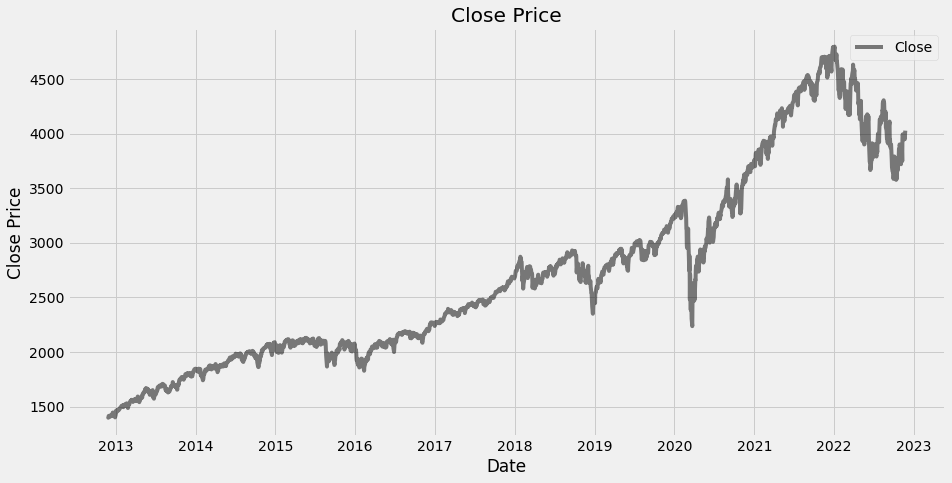

In [17]:
#Our total dataset graph
plt.figure(figsize=(14,7))
plt.title('Close Price')
plt.plot(df['Close'], color="black", alpha = 0.5, label= 'Close')

plt.xlabel ('Date')
plt.ylabel ('Close Price')
plt.legend ()
plt.show()

In [18]:
data = df.filter(['Close'])
dataset = data.values
tlen = int(np.ceil( len(dataset) * .80 )) #Use 80% of dataset

tlen

2015

In [19]:
#Scaling Data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)



In [20]:
scaled_data

array([[0.00216331],
       [0.        ],
       [0.00323465],
       ...,
       [0.75081967],
       [0.76660723],
       [0.77357679]])

In [21]:
train_data = scaled_data[0:int(tlen), :]
# Split the train dataset 
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

        
# Convert to numpy arrays 
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the data #LSTM needs 3D
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1955, 60, 1)

In [22]:
# the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')



2022-12-03 13:49:04.752529: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
batch_size_list=[]
epochs_list=[]
RMSE_list=[]
elist=[1]
blist=[4]
for b in blist:
    for e in elist:
        # Train the model
        model.fit(x_train, y_train, batch_size=b, epochs=e)

        test_data = scaled_data[tlen - 60: , :]
        # Create the data sets x_test and y_test
        
        x_test = []
        y_test = dataset[tlen:, :]
        for i in range(60, len(test_data)):
            x_test.append(test_data[i-60:i, 0])
    
        # numpy array
        x_test = np.array(x_test)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

        # Predict the closing price
        predictions = model.predict(x_test)
        
        predictions = scaler.inverse_transform(predictions) #Unscale

        # root mean squared error (RMSE)
        RMSE = np.sqrt(np.mean(((predictions - y_test) ** 2)))
        
        # root mean absoulate percentage error (MAPE)
        MAPE = np.mean(np.abs((predictions - y_test) / y_test ))*100
        
        batch_size_list.append(b)
        epochs_list.append(e)
        RMSE_list.append(RMSE)



16/16 [==============================] - 0s 10ms/step


In [30]:
print("The model Root Mean Squared Error is:" , RMSE)
print("The model Root Absoulate Percentage Error is:" ,MAPE)

The model Root Mean Squared Error is: 83.24047431906105
The model Root Absoulate Percentage Error is: 1.5484908665705477


/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/2785550556.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


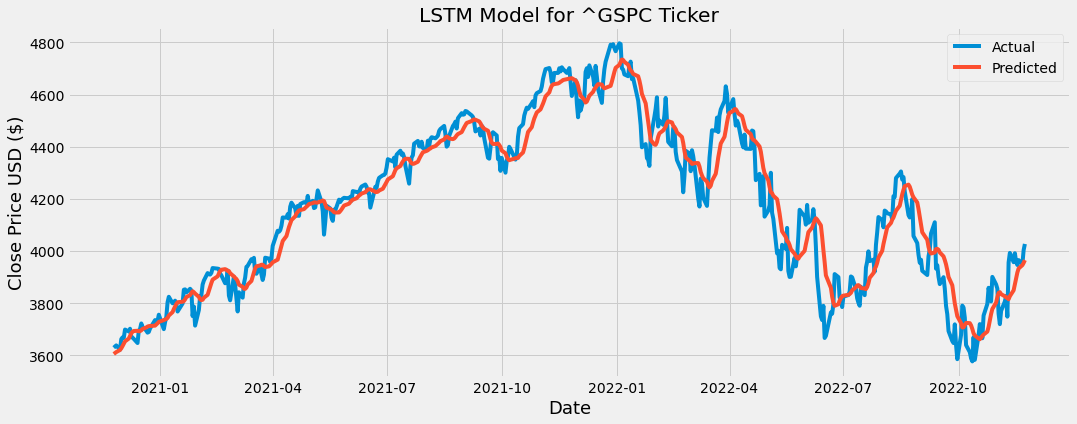

In [37]:
# Plot the data for evaluation
train = data[:tlen]
valid = data[tlen:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('LSTM Model for ^GSPC Ticker')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid[['Close', 'Predictions'] ] )
plt.legend(['Actual', 'Predicted'], loc='upper right')
plt.show()

# Prediction Upcoming days

The prediction is done for the upcoming days but as the LSTM model needs the 60 days actual data for predict the next day the our first day's prediction is realable and we just put that on the report and slides but we do the prediction for the long term based on the predicted data which is not academic thing to do.

In [40]:
Days_2023=pd.read_csv("/Users/macbook/Desktop/Date.csv")
Stock = yf.download("^GSPC", start="2012-11-25", end="2022-11-27")
Stock=Stock.reset_index()
StockMix=pd.concat([Stock, Days_2023])
StockMix=StockMix.reset_index()

StockMix

[*********************100%***********************]  1 of 1 completed


,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2012-11-26 00:00:00,1409.150024,1409.150024,1397.680054,1406.290039,1406.290039,2.948960e+09
1,1,2012-11-27 00:00:00,1406.290039,1409.010010,1398.030029,1398.939941,1398.939941,3.323120e+09
2,2,2012-11-28 00:00:00,1398.770020,1410.310059,1385.430054,1409.930054,1409.930054,3.359250e+09
3,3,2012-11-29 00:00:00,1409.959961,1419.699951,1409.040039,1415.949951,1415.949951,3.356850e+09
4,4,2012-11-30 00:00:00,1415.949951,1418.859985,1411.630005,1416.180054,1416.180054,3.966000e+09
...,...,...,...,...,...,...,...,...
2581,62,2023-01-27,NaN,NaN,NaN,NaN,NaN,NaN
2582,63,2023-01-28,NaN,NaN,NaN,NaN,NaN,NaN
2583,64,2023-01-29,NaN,NaN,NaN,NaN,NaN,NaN
2584,65,2023-01-30,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
#Get the quote
last_60_days = StockMix.dropna().filter(['Close'])[-60:].values

for i in range(len(Days_2023)):
    
    last_60_days=last_60_days[-60: , ]
    last_60_days_scaled = scaler.transform(last_60_days)

    X_test = []
    X_test.append(last_60_days_scaled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # the predicted scaled price
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    
    StockMix.Close.iloc[(len(Stock)+i)]=pred_price
    last_60_days=np.append(last_60_days , pred_price)
    last_60_days=last_60_days.reshape(-1, 1)
    


1/1 [==============================] - 0s 23ms/step


/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

1/1 [==============================] - 0s 23ms/step


/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

1/1 [==============================] - 0s 22ms/step


/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

1/1 [==============================] - 0s 22ms/step


/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

1/1 [==============================] - 0s 32ms/step


/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

1/1 [==============================] - 0s 24ms/step


/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

1/1 [==============================] - 0s 24ms/step


/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

1/1 [==============================] - 0s 24ms/step


/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

1/1 [==============================] - 0s 25ms/step


/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

1/1 [==============================] - 0s 25ms/step


/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

1/1 [==============================] - 0s 25ms/step


/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

1/1 [==============================] - 0s 24ms/step


/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

1/1 [==============================] - 0s 22ms/step


/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

1/1 [==============================] - 0s 25ms/step


/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

1/1 [==============================] - 0s 22ms/step


/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

1/1 [==============================] - 0s 22ms/step


/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

1/1 [==============================] - 0s 24ms/step


/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  StockMix.Close.iloc[(len(Stock)+i)]=pred_price
/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/1875232398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [48]:
NewPred=StockMix.iloc[(len(Stock)):,:][["Date","Close"]]
NewPred=NewPred.set_index('Date')
NewPred.columns = ["Predictions"]
#Our prediction
NewPred.head()

,Predictions
Date,
2022-11-26,3990.119141
2022-11-27,3997.709473
2022-11-28,4003.027344
2022-11-29,4006.990234
2022-11-30,4010.140869


So the only thing that could be reported in an academic report is the prediction of day 2022-11-26 which we have actual data for its prediction but the rest is just our idea to give a try to do the long-term prediction based on the predicted data

In [49]:
valid = data[tlen:]
valid['Predictions'] = predictions


valid=pd.concat([valid,NewPred] )
valid

/var/folders/s5/4b25bvq14pqbm1qxsg0hhlr40000gn/T/ipykernel_1596/2233278607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


,Close,Predictions
Date,,
2020-11-25 00:00:00,3629.649902,3605.439453
2020-11-27 00:00:00,3638.350098,3612.741455
2020-11-30 00:00:00,3621.629883,3620.813965
2020-12-01 00:00:00,3662.449951,3627.020508
2020-12-02 00:00:00,3669.010010,3635.556641
...,...,...
2023-01-27,NaN,4115.127930
2023-01-28,NaN,4116.540527
2023-01-29,NaN,4117.941406


In [50]:
valid.head()

,Close,Predictions
Date,,
2020-11-25 00:00:00,3629.649902,3605.439453
2020-11-27 00:00:00,3638.350098,3612.741455
2020-11-30 00:00:00,3621.629883,3620.813965
2020-12-01 00:00:00,3662.449951,3627.020508
2020-12-02 00:00:00,3669.010010,3635.556641


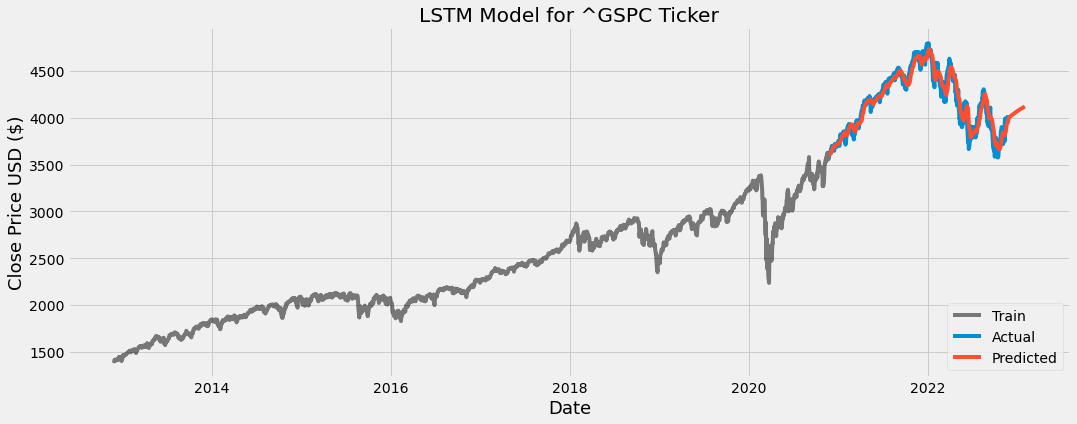

In [51]:
# Plot the data
train = data[:tlen]
#valid = data[tlen:]
#valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('LSTM Model for ^GSPC Ticker')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'] , color='black', alpha=0.5)
plt.plot(valid[['Close', 'Predictions'] ] )
plt.legend(['Train', 'Actual', 'Predicted'], loc='lower right')
plt.show()

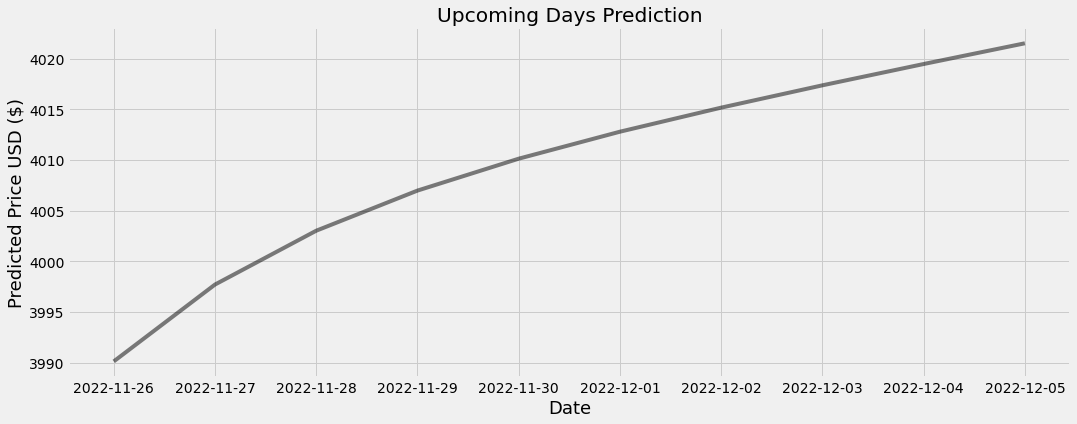

In [52]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Upcoming Days Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Predicted Price USD ($)', fontsize=18)
plt.plot(NewPred['Predictions'].iloc[:10] , color='black', alpha=0.5)
plt.show()